기본값 : 0  
INFO 로그 필터링 : 1  
WARNING 로그 필터링 : 2  
ERROR 로그 필터링 : 3  

In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-11-26 17:44:24.369635: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15340443208969704086
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11962482688
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7893425501399266219
 physical_device_desc: "device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:b3:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [4]:
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = 'D2Coding'

In [5]:
tf.__version__

'2.10.0'

In [6]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tqdm import tqdm

# 트랜스포머 구현

## 에셋 임베딩 레이어

In [7]:
class SeqAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, window_size, d_model, is_decoder=False, **kwargs):
        super(SeqAndPositionEmbedding, self).__init__(**kwargs)
        self.d_model = d_model
        self.is_decoder = is_decoder
        self.__windowsize = window_size
        
        self.esset_emb = tf.keras.layers.Dense(self.d_model) #입력 데이터 shape : (batch_size, window_size)
        self.pos_emb = tf.keras.layers.Embedding(self.__windowsize, self.d_model)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "__windowsize":self.__windowsize,
            "is_decoder":self.is_decoder,
        })
        return config
    
    def call(self, x):
        L = tf.shape(x)[-1] if self.is_decoder else self.__windowsize
        batch_size = tf.shape(x)[0]
        
        positions = tf.range(start=0, limit= L, delta=1)
        positions = self.pos_emb(positions)
        positions = positions[tf.newaxis,:]
        x_ = tf.reshape(x,(batch_size,L,1))
        x_ = self.esset_emb(x_)
        
        return x_ + positions

## 인코더 레이어

In [8]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 이번 일에서는 패딩이 존재X -> 패딩마스크X

    # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
    assert d_model%num_heads==0,  f'It is in {name}'
    d_model_each_head = int(d_model/num_heads)
    attention = tf.keras.layers.MultiHeadAttention(num_heads, d_model_each_head, name=f"{name}_MHAtt")(
        query = inputs, value = inputs, #key = inputs
    )

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs+attention)

    # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention+outputs)

    return tf.keras.Model(inputs=[inputs], outputs=outputs, name=name)

In [9]:
def encoder(window_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(window_size,), name="inputs")

    # 이번 일에서는 패딩이 존재X -> 패딩마스크X

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = SeqAndPositionEmbedding(window_size,d_model)(inputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 인코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
                                dropout=dropout, name=f"encoder_layer_{i}",)([outputs])
        outputs = tf.keras.layers.LayerNormalization()(outputs)

    return tf.keras.Model(inputs=[inputs], outputs=outputs, name=name)

## 룩-어헤드 마스크(Look-ahead mask)

In [10]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask(0)하는 함수
def create_look_ahead_mask(inputs,padding_length:int=0):
    
    assert padding_length >= 0
    
    input_shape = tf.shape(inputs)
    batch_size, sequence_length = input_shape[0], input_shape[1]
    i = tf.range(sequence_length)[:, tf.newaxis]
    j = tf.range(sequence_length-padding_length)
    mask = tf.cast(i >= j, dtype="int32")
    mask = tf.concat([mask,tf.zeros([sequence_length,padding_length], dtype="int32")],axis=-1)
    mask = tf.reshape(mask, (1, sequence_length, sequence_length))
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
        axis=0,
    )
    return tf.tile(mask, mult)

In [11]:
tmp = tf.constant(np.arange(3*10*7).reshape((3,10,7)), dtype=tf.float32)

create_look_ahead_mask(tmp,4)

<tf.Tensor: shape=(3, 10, 10), dtype=int32, numpy=
array([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]],

       [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]],

       [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0

## 디코더 레이어

In [12]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

    # 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.Input(shape=(None, None), name="look_ahead_mask")

    # 패딩 마스크X

    # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
    assert d_model%num_heads==0,  f'It is in {name}'
    d_model_each_head = int(d_model/num_heads)
    attention1 = tf.keras.layers.MultiHeadAttention(num_heads, d_model_each_head, name=f"{name}_MHAtt_1")(
        query = inputs, value = inputs, attention_mask = look_ahead_mask, #key = inputs
    )

    # 잔차 연결과 층 정규화
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1+inputs)

    # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
    attention2 = tf.keras.layers.MultiHeadAttention(num_heads, d_model_each_head, name=f"{name}_MHAtt_2")(
        query = attention1, value = enc_outputs, #key = enc_outputs
    )

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2+attention1)

    # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs+attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask],
        outputs=outputs,
        name=name)

In [13]:
def decoder(forecast_range, num_layers, dff,
            d_model, num_heads, dropout,
            name='transformer_decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    
    # 포지셔널 인코딩 + 드롭아웃
    embeddings = SeqAndPositionEmbedding(forecast_range,d_model,is_decoder=True)(inputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
    look_ahead_mask = create_look_ahead_mask(outputs,forecast_range)
    
    # 디코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
                                dropout=dropout, name=f'decoder_layer_{i}',)(inputs=[outputs, enc_outputs, look_ahead_mask])
        outputs = tf.keras.layers.LayerNormalization()(outputs)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs],
        outputs=outputs,
        name=name)


## 인코더-디코더 어텐션

In [14]:
def attention_enc_dec(window_size,d_model,num_heads,ref_seq_enc_num,name='attention_enc2dec'):
    target_outputs = tf.keras.Input(shape=(window_size,d_model), name="target_outputs")
    ref_outputs = [tf.keras.Input(shape=(window_size,d_model), name=f"ref_outputs_{i}") for i in range(ref_seq_enc_num)]
    
    total_outputs = [target_outputs]
    total_outputs.extend(ref_outputs)
    
    concat_outputs = tf.keras.layers.Concatenate(axis=-1,name = "concat_enc2dec")(total_outputs)
    concat_outputs = tf.keras.layers.Dense(d_model)(concat_outputs)
        
    enc_outputs = tf.keras.layers.MultiHeadAttention(num_heads, d_model, name="multi_head_attention_1")(
        query = concat_outputs, value = concat_outputs, #key = inputs
    )

    return tf.keras.Model(inputs=total_outputs, outputs=enc_outputs, name=name)

In [15]:
enc_dec_att = attention_enc_dec(30,128,8,3)
enc_dec_att.summary()

Model: "attention_enc2dec"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 target_outputs (InputLayer)    [(None, 30, 128)]    0           []                               
                                                                                                  
 ref_outputs_0 (InputLayer)     [(None, 30, 128)]    0           []                               
                                                                                                  
 ref_outputs_1 (InputLayer)     [(None, 30, 128)]    0           []                               
                                                                                                  
 ref_outputs_2 (InputLayer)     [(None, 30, 128)]    0           []                               
                                                                                  

## 멀티 인풋 트랜스포머

### 시퀀스 어탠션(sequence attention)

In [16]:
class SeqAttention(tf.keras.layers.Layer):
    def __init__(self, num_seq, window_size, d_model, attmap_dropout=0.1, name="sequence_attention"):
        super(SeqAttention, self).__init__(name=name)
        self.num_seq = num_seq
        self.window_size = window_size
        self.d_model = d_model
        self.attmap_dropout = attmap_dropout
        
        #필요 레이어
        ## 어탠션 맵을 만들 레이어
        self.att_concate = tf.keras.layers.Concatenate(axis=1)
        #self.attmap_dense= tf.keras.layers.Dense(self.num_seq*self.d_model)
        self.attmap_dense=tf.keras.Sequential([
            tf.keras.layers.Dense(int(self.num_seq*self.d_model*0.5)),
            tf.keras.layers.Dropout(self.attmap_dropout),
            tf.keras.layers.Dense(self.num_seq*self.d_model)
        ])
        self.att_softmax = tf.keras.layers.Softmax()
        
        #어탠션맵 생성 이후 처리
        
        #(+ 이부분 좀 생각해보자. 어쩌면 d_model 방향으로 차례로 넣는걸 해야할지도?)
        self.concate = tf.keras.layers.Concatenate(axis=2) #d_model 방향으로 concatenate 
        self.dense = tf.keras.layers.Dense(self.d_model, activation=None) #
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_seq":self.num_seq,
            "window_size":self.window_size,
            "d_model": self.d_model,
            "attmap_dropout":self.attmap_dropout,
        })
        return config
    
    
    def call(self,query_,key_):
        '''
        input 모양 : 
            쿼리 -> (None, window_size, d_model, num_seq)
            키/밸류 -> (None, num_seq, window_size)
        
        attention map 모양 : (None, 1, d_model, num_seq)
        
        output 모양:
            (None, window_size, 2 * d_model, num_seq)
        '''
        
        #Attention map 만들기
        min_seq = tf.math.reduce_min(key_,axis=1) #(None, window_size)
        avg_seq = tf.math.reduce_mean(key_,axis=1) #(None, window_size)
        max_seq = tf.math.reduce_max(key_,axis=1) #(None, window_size)
        
        att_input = self.att_concate([min_seq,avg_seq,max_seq]) #(None, 3 * window_size)
        att_score = self.attmap_dense(att_input) #(None, d_model * num_seq)
        att_map = self.att_softmax(att_score)
        att_map = tf.reshape(att_map,[-1,1,self.d_model,self.num_seq]) #(None, 1, d_model, num_seq)
        
        #Attention
        att_out = tf.math.multiply(query_, att_map)
        
        #쿼리와의 concatenate
        concat_query = self.concate([query_, att_out]) #(None, window_size, 2*d_model, num_seq)
        
        #(None, window_size, 2*d_model, num_seq) -> (None, window_size, d_model, num_seq)
        concat_query = tf.transpose(concat_query,[0,1,3,2])
        concat_query = tf.reshape(concat_query,[-1,2*self.d_model])
        out = self.dense(concat_query)
        out = tf.reshape(out,[-1,self.window_size,self.num_seq,self.d_model])
        out = tf.transpose(out,[0,1,3,2])
        
        return out

### 멀티 인풋 트랜스포머

In [17]:
def multi_input_transformer(num_seq,window_size,num_layers,dff,d_model,num_heads,dropout,name=None):
    inputs = tf.keras.Input(shape=(num_seq,window_size), name="inputs")
    
    inputs_split = tf.split(inputs, num_or_size_splits=num_seq, axis=1)
    for i in range(num_seq):
        inputs_split[i] = tf.reshape(inputs_split[i],(-1,window_size))
    
    siamese_enc = encoder(window_size=window_size, num_layers=num_layers, dff=dff,
                              d_model=d_model, num_heads=num_heads, dropout=dropout,name = "siamese_encoder")
    
    outputs_concat = []
    for i in range(num_seq):
        #siamese 구조
        outputs = siamese_enc(inputs=[inputs_split[i]])
        #outputs의 shape = (None,window_size,d_model)
        outputs = tf.reshape(outputs,(-1,window_size,d_model,1))
        
        outputs_concat.append(outputs)
    outputs_concat = tf.keras.layers.Concatenate(axis=3,name = "concatenate")(outputs_concat)
    
    outputs_concat_att = SeqAttention(num_seq=num_seq,
                                      window_size=window_size,
                                      d_model=d_model,
                                      attmap_dropout=0.1,
                                      name="sequence_attention")(query_ = outputs_concat, key_=inputs)
    
    reduce_mean_outputs = tf.math.reduce_mean(outputs_concat_att,axis=3)#어탠션 수행 예정!
    return tf.keras.Model(inputs=[inputs], outputs=reduce_mean_outputs, name=name)

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


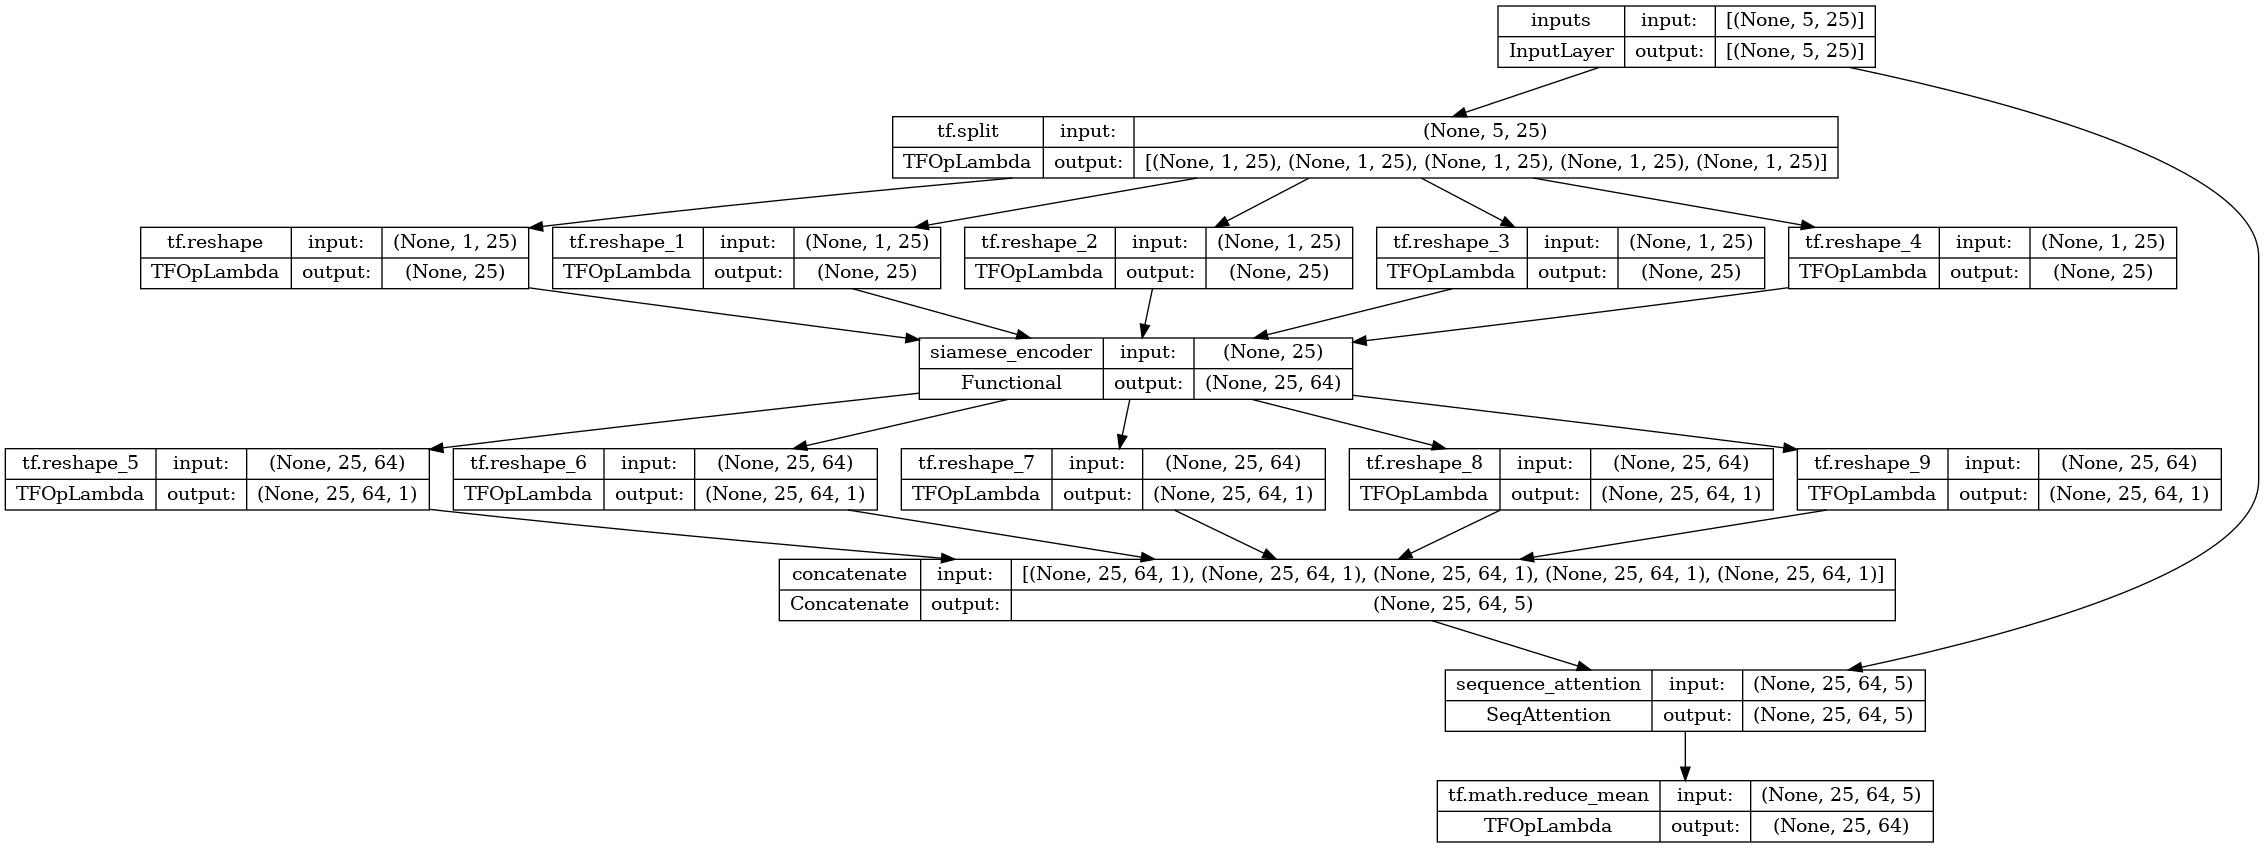

In [18]:
tf.keras.backend.clear_session()

pos_enc = multi_input_transformer(num_seq = 5,
                                  window_size=25,
                                  num_layers=4,
                                  dff=128,
                                  d_model=64,
                                  num_heads=8,
                                  dropout=0.1,
                                  name='multi_input_transformer')
tf.keras.utils.plot_model(pos_enc, to_file='./imgs/multi_inputs_transformer.png', show_shapes=True)

## MEaI 트랜스포머

In [19]:
class create_decoder_input(tf.keras.layers.Layer):
    def __init__(self, forecast_range):
        super(create_decoder_input,self).__init__()
        self.forecast_range = forecast_range
        
    def get_config(self):
        config = super().get_config()
        config.update({
            'forecast_range' : self.forecast_range
        })
        return config
    
    def call(self, enc_input):
        batch_size = tf.shape(enc_input)[0]
        dec_input = tf.zeros([batch_size,self.forecast_range])
        dec_input = tf.concat([enc_input,dec_input],axis=-1)
        return tf.cast(dec_input,enc_input.dtype)

In [20]:
def MEaI_transformer(window_size, forecast_range, ref_num_list:list, num_layers, dff,
                     d_model, num_heads, dropout,ref_encoder_name=None,
                     name="MEaI_transformer"):
    
    assert len(ref_num_list) > 0
    assert 0 not in ref_num_list
    assert (ref_encoder_name is None) or type(ref_encoder_name) == list
    if type(ref_encoder_name) == list:
        assert len(ref_encoder_name) == len(ref_num_list)

    # 목표 시퀀스 인코더의 입력
    target_inputs = tf.keras.Input(shape=(window_size,), name="target_inputs")
    
    # 참조 시퀀스 인코더의 입력
    ref_inputs = []
    for idx,s in enumerate(ref_num_list):
        ref_in = tf.keras.Input(shape=(s,window_size), name=f"ref_inputs_{idx}")
        ref_inputs.append(ref_in)
    
    # 디코더의 입력
    #dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")
    dec_inputs = create_decoder_input(forecast_range)(target_inputs)
    
    #목표 시퀀스 인코더
    Target_seq_outputs = encoder(window_size=window_size, num_layers=num_layers, dff=dff,
                          d_model=d_model, num_heads=num_heads, dropout=dropout,name = "Target_seq_encoder")(inputs=[target_inputs])
    
    
    #참조 시퀀스 멀티 인풋 인코더
    ref_seq_outputs = []
    
    if ref_encoder_name is None:
        for idx, s in enumerate(ref_num_list):
            ref_seq = multi_input_transformer(num_seq=s,window_size=window_size,num_layers=num_layers,dff=dff,
                                              d_model=d_model,num_heads=num_heads,dropout=dropout,name=f"ref_seq_encoder_{idx}")(inputs=[ref_inputs[idx]])
            ref_seq_outputs.append(ref_seq)
    else:
        for idx, s in enumerate(ref_num_list):
            ref_seq = multi_input_transformer(num_seq=s,window_size=window_size,num_layers=num_layers,dff=dff,
                                              d_model=d_model,num_heads=num_heads,dropout=dropout,name=ref_encoder_name[idx])(inputs=[ref_inputs[idx]])
            ref_seq_outputs.append(ref_seq)
    
    #concatenate-attention
    total_encode_output = [Target_seq_outputs]
    total_encode_output.extend(ref_seq_outputs)
    
    enc_outputs = attention_enc_dec(window_size,d_model,num_heads,len(ref_num_list),name='attention_enc2dec')(inputs=total_encode_output)
    # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    
    dec_outputs = decoder(forecast_range=forecast_range, num_layers=num_layers, dff=dff,
                          d_model=d_model, num_heads=num_heads, dropout=dropout,)(inputs=[dec_inputs, enc_outputs])

    # 다음 예측을 위한 출력층
    #dec_outputs = tf.keras.layers.Dense(units=32, name="outputs_dense")(dec_outputs)
    outputs = tf.keras.layers.Dense(units=1, name="output_dense")(dec_outputs)
    outputs = tf.keras.layers.Lambda(lambda x: x[:,-forecast_range:,:], name='outputs')(outputs)
    
    total_inputs=[target_inputs]
    total_inputs.extend(ref_inputs)
    #total_inputs.append(dec_inputs)
    
    return tf.keras.Model(inputs=total_inputs, outputs=outputs, name=name)

# 기본 모델 구조

In [ ]:
params = {
    'window_size':30,
    'forecast_range':24,
    'num_layers':4,
    'dff':256,
    'd_model':128,
    'num_heads':4,
    'dropout':0.1
}

In [ ]:
tf.keras.backend.clear_session()

model = MEaI_transformer(
    window_size = params['window_size'],
    forecast_range = params['forecast_range'],
    ref_num_list = [10,5],
    num_layers = params['num_layers'],
    dff = params['dff'],
    d_model = params['d_model'],
    num_heads = params['num_heads'],
    dropout = params['dropout'],
    ref_encoder_name=None,
    name="MEaI_transformer")

tf.keras.utils.plot_model(model, to_file='./imgs/MEaI_transformer.png', show_shapes=True)
model.summary()

# 데이터 생성 & 학습

## PM10

### 데이터 처리

In [ ]:
params_pm10 = {
    'window_size':25,
    'forecast_range':24,
    'num_layers':4,
    'dff':512,
    'd_model':256,
    'num_heads':4,
    'dropout':0.1
}

In [ ]:
PM10 = pd.read_csv('./data/weather_and_pm10.csv')
PM10.일시 = pd.DatetimeIndex(PM10.일시,freq='H')

PM10.index = PM10.일시
PM10 = PM10.drop(columns = ['일시','풍향'])

PM10_col = PM10.columns.copy()
PM10_index = PM10.index.copy()

#scaler_pm10 = StandardScaler()
#scaler_pm10.fit(PM10)
#PM10 = scaler_pm10.transform(PM10)
PM10[['기압','시정']] = PM10[['기압','시정']]*0.01

PM10 = pd.DataFrame(PM10,columns = PM10_col,index=PM10_index)

PM10

In [ ]:
plt.figure(figsize=(10,8))

sns.heatmap(PM10.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [ ]:
seoul_pm10 = PM10['서울pm10'].to_numpy()
#index_data = PM10.iloc[:,:8].to_numpy()
index_data = PM10['시정'].to_numpy().reshape([-1,1])
other_pm10 = PM10[['관악pm10','수원pm10']].to_numpy()

print(seoul_pm10.shape,other_pm10.shape,index_data.shape)

In [ ]:
split_by_window_target = []
split_by_window_index = []
split_by_window_other = []
label_forecast=[]

for i in tqdm(range( seoul_pm10.shape[0] - params_pm10['window_size'] - params_pm10['forecast_range'] + 1 )):
    split_by_window_target.append(seoul_pm10[i:i+params_pm10['window_size']])
    split_by_window_index.append(index_data[i:i+params_pm10['window_size'],:].T)
    split_by_window_other.append(other_pm10[i:i+params_pm10['window_size'],:].T)
    
    label_forecast.append(seoul_pm10[i+params_pm10['window_size']-1:i+params_pm10['window_size']+params_pm10['forecast_range']])

split_by_window_target = np.array(split_by_window_target)
split_by_window_index = np.array(split_by_window_index)
split_by_window_other = np.array(split_by_window_other)
label_forecast = np.array(label_forecast)


print(split_by_window_target.shape)
print(split_by_window_index.shape)
print(split_by_window_other.shape)
print(label_forecast.shape)

In [ ]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
# inputs,pos_inputs,neg_inputs,index_inputs, dec_inputs

split_point=round(label_forecast.shape[0]*0.8)
print(split_point)

BATCH_SIZE = 128
BUFFER_SIZE = 20000

train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'target_inputs': split_by_window_target[:split_point,:],
        'ref_inputs_0':split_by_window_index[:split_point,:,:],
        'ref_inputs_1':split_by_window_other[:split_point,:,:],
        'dec_inputs': label_forecast[:split_point,:-1] #teaching force
    },
    {
        'outputs': label_forecast[:split_point, 1:,np.newaxis] #(None,24,1)
    },
))

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'target_inputs': split_by_window_target[split_point:,:],
        'ref_inputs_0':split_by_window_index[split_point:,:,:],
        'ref_inputs_1':split_by_window_other[split_point:,:,:],
        'dec_inputs': label_forecast[split_point:,:-1] #teaching force
    },
    {
        'outputs': label_forecast[split_point:, 1:,np.newaxis] #(None,24,1)
    },
))
test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

### 모델 학습

In [ ]:
del model

In [ ]:
tf.keras.backend.clear_session()

model = MEaI_transformer(
    window_size = params_pm10['window_size'],
    forecast_range = params_pm10['forecast_range'],
    ref_num_list = [1,2],
    num_layers = params_pm10['num_layers'],
    dff = params_pm10['dff'],
    d_model = params_pm10['d_model'],
    num_heads = params_pm10['num_heads'],
    dropout = params_pm10['dropout'],
    ref_encoder_name=['index_seq_encoder','other_pm10_encoder'],
    name="MEaI_transformer")

tf.keras.utils.plot_model(model, to_file='./imgs/PM10_MEaI_transformer.png', show_shapes=True)


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Nadam(),
              loss = tf.keras.losses.MeanSquaredError()
             )

In [ ]:
callback_path = './result/MEaI_transformer/PM10'

os.makedirs(f'{callback_path}/ckpt', exist_ok=True)
ckpt_path = callback_path+'/ckpt/model_ckpt'
callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    monitor='val_loss',
    save_best_only = True,
    save_weights_only=True,
    verbose=1
)

os.makedirs(f'{callback_path}/tsbd', exist_ok=True)
callback_tsbd = tf.keras.callbacks.TensorBoard(f'{callback_path}/tsbd')

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.95 ** (epoch-5)
callback_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
lr = 0.001
e = np.arange(20)

r = [scheduler(e_,lr) for e_ in e]
plt.plot(e,r)

In [ ]:
history_pm10 = model.fit(train_dataset, epochs=20, validation_data=test_dataset, verbose = 1, callbacks=[callback_ckpt,callback_scheduler,callback_tsbd])

In [ ]:
model.load_weights('./result/MEaI_transformer/PM10/ckpt/model_ckpt')

### 결과 예측

In [ ]:
params_pm10

In [ ]:
fore_input = PM10['서울pm10'].to_numpy()[-params_pm10['window_size']-params_pm10['forecast_range']:-params_pm10['forecast_range']].reshape([1,25])
#fore_input_index = PM10.iloc[:,:8].to_numpy()[-params_pm10['window_size']-params_pm10['forecast_range']:-params_pm10['forecast_range']].transpose().reshape([1,8,25])
fore_input_index = PM10['시정'].to_numpy()[-params_pm10['window_size']-params_pm10['forecast_range']:-params_pm10['forecast_range']].transpose().reshape([1,1,25])
fore_input_other = PM10[['관악pm10','수원pm10']].to_numpy()[-params_pm10['window_size']-params_pm10['forecast_range']:-params_pm10['forecast_range']].transpose().reshape([1,2,25])
fore_input_dec = fore_input[0,-1].reshape([1,1])

print(fore_input.shape)
print(fore_input_index.shape)
print(fore_input_other.shape)
fore_input_dec

In [ ]:
out = model([fore_input,fore_input_index,fore_input_other,fore_input_dec])
fore_input_dec_1 = np.concatenate([fore_input_dec,out.numpy().reshape((1,-1))],axis=-1)
fore_input_dec_1

In [ ]:
for _ in range(23):
    out = model([fore_input,fore_input_index,fore_input_other,fore_input_dec_1])
    fore_input_dec_1 = np.concatenate([fore_input_dec,out.numpy().reshape((1,-1))],axis=-1)
print(out)
print(fore_input_dec_1)

In [ ]:
plt.plot(out.numpy().reshape(-1))
plt.plot(PM10['서울pm10'][-24:].to_numpy())

In [ ]:
RESULT_pm10 = pd.concat([pd.DataFrame(out.numpy()[0]),PM10['서울pm10'][-24:].reset_index(drop=True)],axis=1)
RESULT_pm10.columns = ['forecast(MEaI Transformer)','Real value']

#RESULT_pm10 = RESULT_pm10*np.sqrt(scaler_pm10.var_[-2])+scaler_pm10.mean_[-2] #scale 되돌림

#RESULT_pm10.to_csv('./MEaI 결과(PM10).csv',index=False)

## KOSPI

### 데이터 처리

In [46]:
params_kospi = {
    'window_size':60,
    'forecast_range':20,
    'num_layers':6,
    'dff':1024,
    'd_model':512,
    'num_heads':16,
    'dropout':0.1
}

In [47]:
KOSPI = pd.read_csv('./data/kospi_financeIndex_and_stock.csv')
KOSPI.Date = pd.DatetimeIndex(KOSPI.Date)

KOSPI.index = KOSPI.Date
KOSPI = KOSPI.drop(columns = ['Date'])

KOSPI_col = KOSPI.columns.copy()
KOSPI_index = KOSPI.index.copy()

scaler_kospi = StandardScaler()
scaler_kospi.fit(KOSPI)
KOSPI = scaler_kospi.transform(KOSPI)

KOSPI = pd.DataFrame(KOSPI,columns = KOSPI_col,index=KOSPI_index)

# 데이터가 많기 때문에 개별 회사 주식의 종가는 
# KOSPI와의 pearson 상관계수의 절대값이 큰 순서로 양/음의 개수를 정해서 가져옴
close_stock = KOSPI.iloc[:,8:].copy()
close_stock = pd.concat([KOSPI['KOSPI'],close_stock],axis=1)
corr_name = close_stock.corr().sort_values(by='KOSPI',ascending=False).index.to_list()

select_range = 10
select_by_corr = []
select_corr_pos = corr_name[1:select_range+1]
select_corr_neg = corr_name[-select_range:]
select_by_corr.extend(select_corr_pos)
select_by_corr.extend(select_corr_neg)

print(close_stock.corr().sort_values(by='KOSPI',ascending=False)['KOSPI'][select_by_corr])
print('-'*50)

select_col = select_by_corr
select_index = KOSPI.columns[:8].to_list()
select_col.extend(select_index)
KOSPI_MEaI = KOSPI[select_col].copy()
KOSPI_MEaI


LG전자_close       0.962965
금호석유_close       0.911382
현대차_close        0.903168
삼성전자우_close      0.898694
그린케미칼_close      0.897949
삼성전자_close       0.891212
영풍제지_close       0.887851
한온시스템_close      0.873761
서울식품_close       0.865326
카카오_close        0.864398
한국전력_close      -0.425078
강원랜드_close      -0.427269
KR모터스_close     -0.467246
쌍방울_close       -0.478882
마니커_close       -0.480190
KT&G_close      -0.490517
인디에프_close      -0.505008
한창_close        -0.538270
베트남개발1_close    -0.586498
다이나믹디자인_close   -0.785547
Name: KOSPI, dtype: float64
--------------------------------------------------


,LG전자_close,금호석유_close,현대차_close,삼성전자우_close,그린케미칼_close,삼성전자_close,영풍제지_close,한온시스템_close,서울식품_close,카카오_close,...,베트남개발1_close,다이나믹디자인_close,KOSPI,KQ11,USD/KRW,JPY/KRW,US500,IXIC,DGS10,POILDUBUSDM
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,-1.003671,-1.008772,-0.209728,-1.428262,-0.478895,-1.673115,-0.564021,-0.646383,-0.806400,-0.558942,...,1.158000,1.627677,-1.074499,-0.628396,0.686106,-1.883796,-1.305567,-1.148805,0.456163,-2.186352
2016-01-05,-0.947906,-1.010689,-0.222922,-1.420618,-0.497562,-1.669367,-0.560883,-0.697047,-0.793575,-0.549598,...,1.354445,1.575549,-1.044779,-0.581656,1.009231,-1.114412,-1.299943,-1.152484,0.470515,-2.186352
2016-01-06,-0.935514,-0.995354,-0.315279,-1.433358,-0.518939,-1.710597,-0.629907,-0.688603,-0.832051,-0.539193,...,1.256222,1.570949,-1.057657,-0.557840,1.042397,-1.026605,-1.336675,-1.170052,0.370050,-2.186352
2016-01-07,-0.926220,-1.016440,-0.381249,-1.466483,-0.509003,-1.725589,-0.698931,-0.781485,-0.857701,-0.548537,...,1.256222,1.570949,-1.110935,-0.614478,1.286754,-0.764460,-1.402183,-1.216228,0.341345,-2.186352
2016-01-08,-0.898337,-0.999187,-0.407637,-1.456291,-0.509003,-1.715594,-0.686381,-0.899699,-0.870526,-0.559459,...,1.207111,1.561686,-1.077377,-0.592895,1.205058,-0.630191,-1.431430,-1.230680,0.298289,-2.186352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,1.598690,1.525382,1.676998,1.889351,1.287547,1.850175,2.074573,0.831294,1.373876,1.805682,...,-1.297565,-1.861798,1.687053,1.824926,0.963872,-0.239853,2.462297,2.243570,-0.605902,1.239557
2021-12-27,1.645160,1.554136,1.624222,1.863870,1.275503,1.831434,2.080848,0.789075,1.348226,1.766857,...,-1.248454,-1.882432,1.654531,1.854250,0.974116,-0.225895,2.553121,2.312327,-0.634606,1.239557
2021-12-28,1.645160,1.534967,1.637416,1.863870,1.269482,1.837681,2.124772,0.831294,1.373876,1.779799,...,-1.248454,-1.880515,1.706774,1.973928,0.967531,-0.288495,2.546400,2.284072,-0.620254,1.239557


In [48]:
print(select_corr_pos)
print('-'*30)
print(select_corr_neg)
print('-'*30)
print(select_index[1:])

['LG전자_close', '금호석유_close', '현대차_close', '삼성전자우_close', '그린케미칼_close', '삼성전자_close', '영풍제지_close', '한온시스템_close', '서울식품_close', '카카오_close']
------------------------------
['한국전력_close', '강원랜드_close', 'KR모터스_close', '쌍방울_close', '마니커_close', 'KT&G_close', '인디에프_close', '한창_close', '베트남개발1_close', '다이나믹디자인_close']
------------------------------
['KQ11', 'USD/KRW', 'JPY/KRW', 'US500', 'IXIC', 'DGS10', 'POILDUBUSDM']


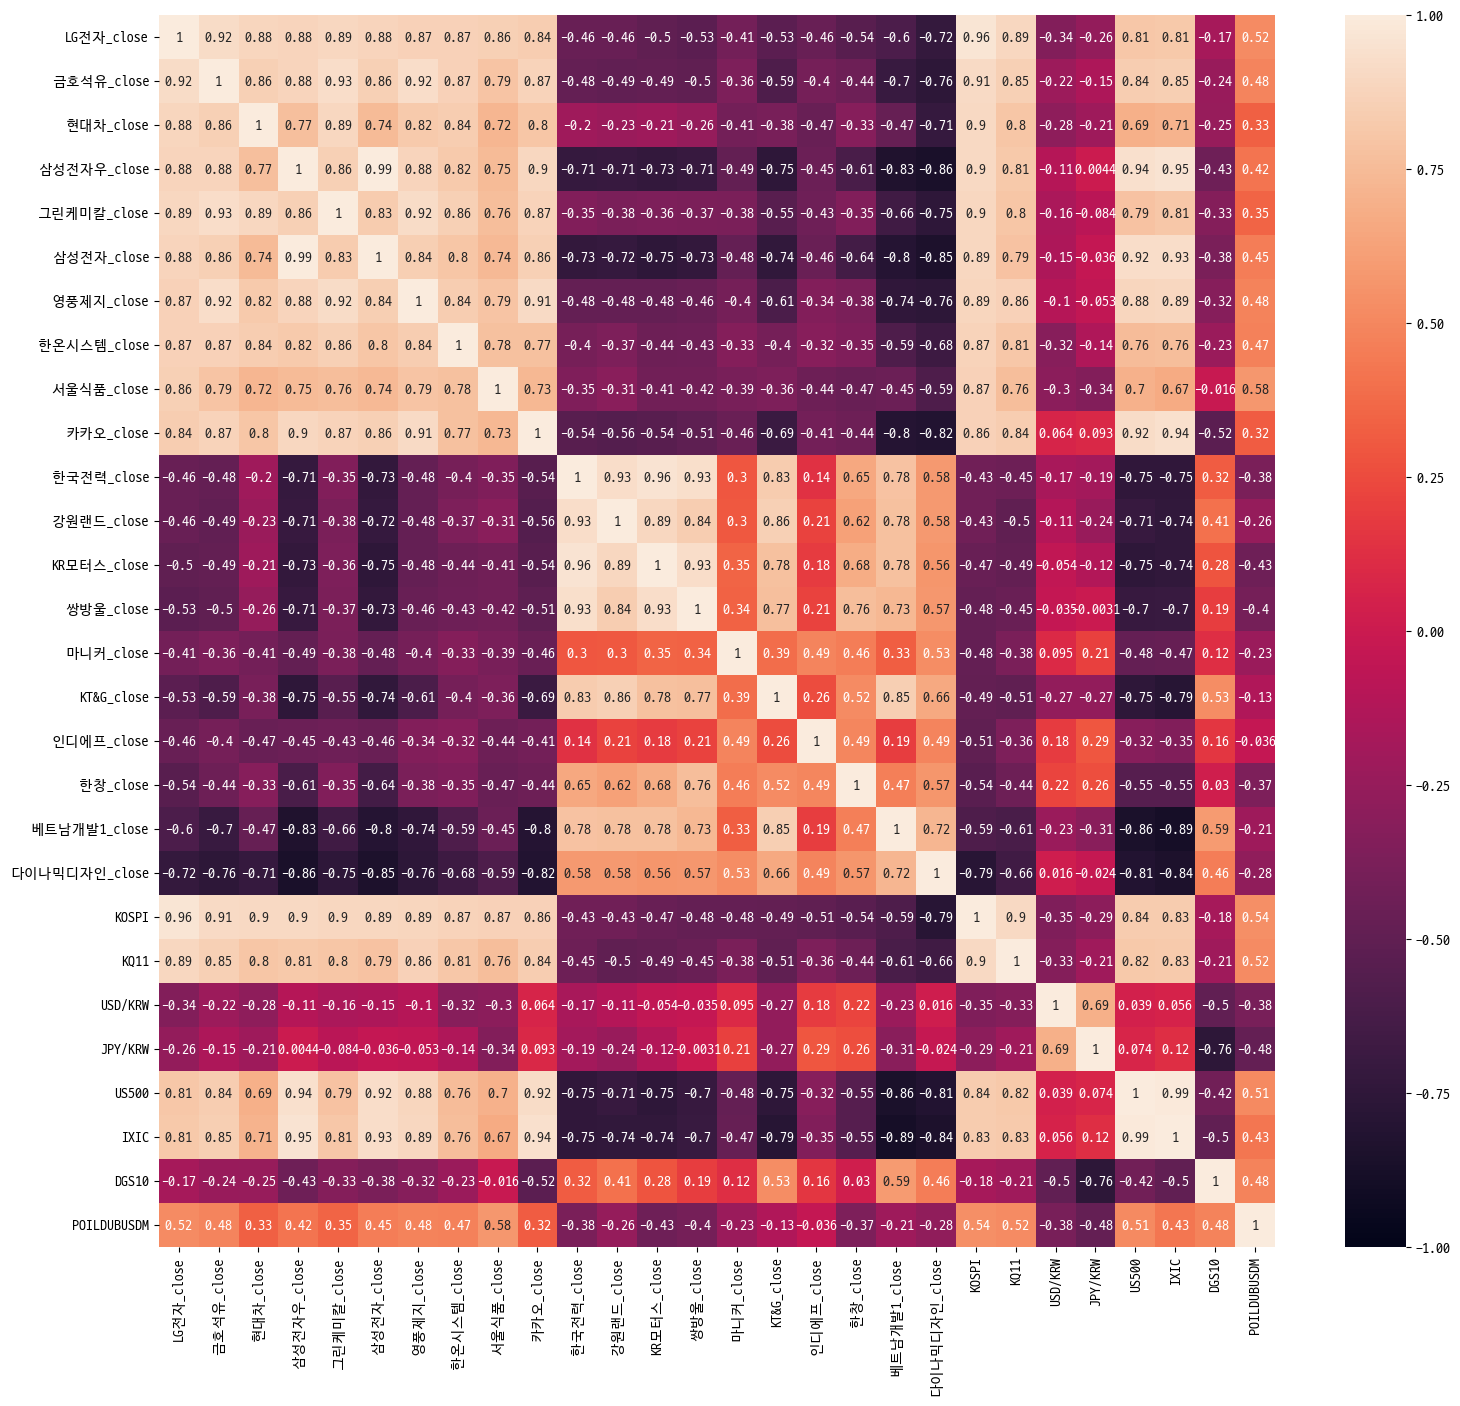

In [49]:
plt.figure(figsize=(18,16))

sns.heatmap(KOSPI_MEaI.corr(), vmin=-1, vmax=1, annot=True)
plt.savefig('./imgs/KOSPI_heatmap.png')
plt.show()

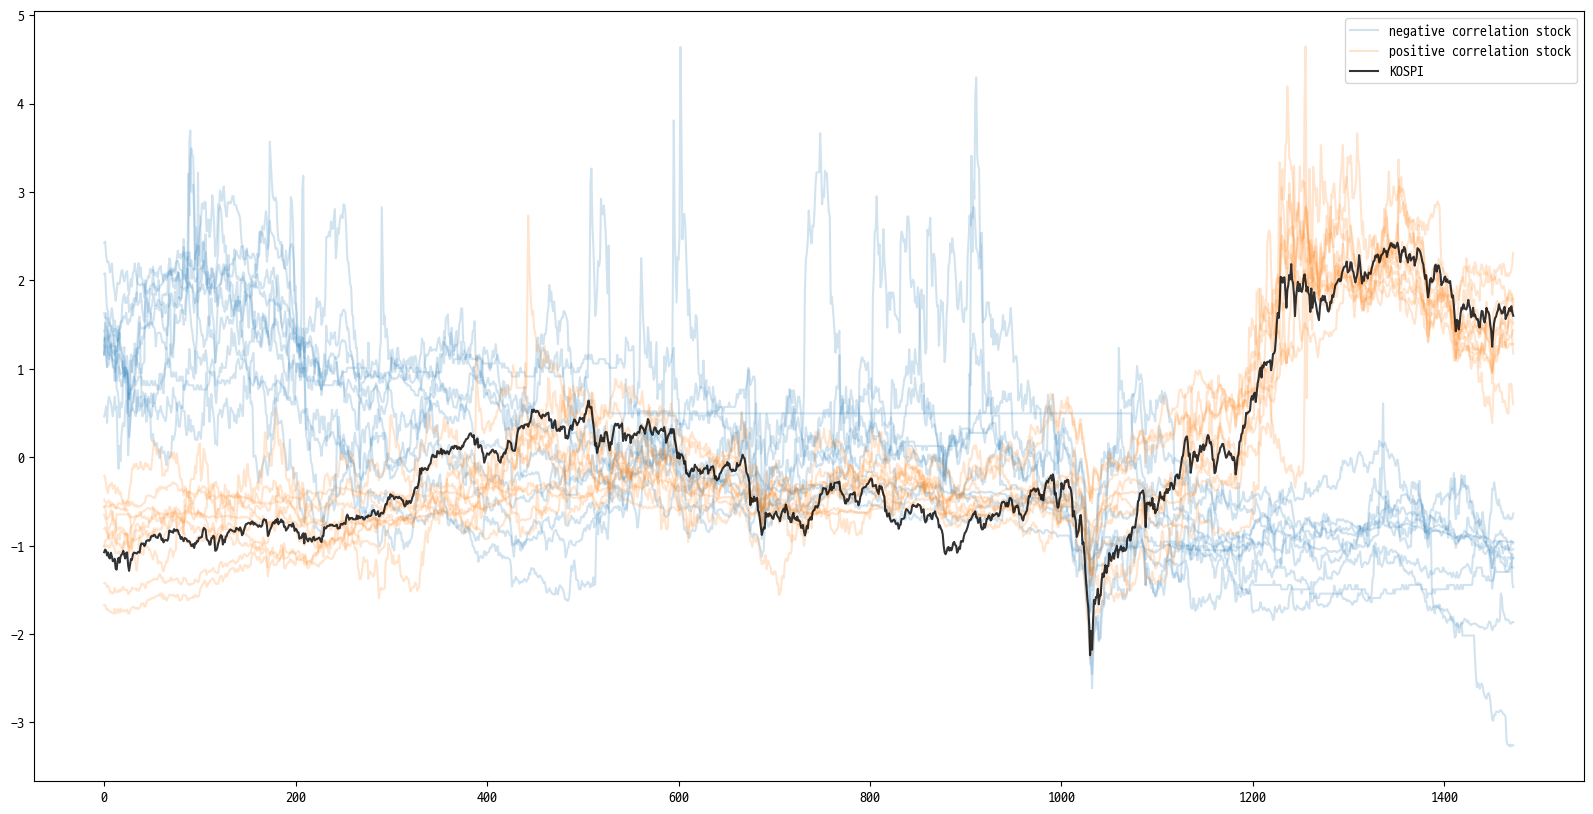

In [50]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot()

handle0 = ax.plot(KOSPI_MEaI[select_corr_neg].reset_index(drop=True),color = 'C0',alpha=0.2)
handle1 = ax.plot(KOSPI_MEaI[select_corr_pos].reset_index(drop=True),color = 'C1',alpha=0.2)
#handle2 = ax.plot(KOSPI_MEaI[select_index[1:]].reset_index(drop=True),color = 'C2',alpha=0.2)
handle3 = ax.plot(KOSPI_MEaI['KOSPI'].reset_index(drop=True),color = 'black',alpha=0.8)

#ax.legend(handles=[handle0[0],handle1[0],handle2[0],handle3[0]], labels=['negative correlation stock','positive correlation stock','other index','KOSPI'])
ax.legend(handles=[handle0[0],handle1[0],handle3[0]], labels=['negative correlation stock','positive correlation stock','KOSPI'])

plt.savefig('./imgs/KOSPI_corr.png')
plt.show()

In [51]:
print(select_corr_pos)
print('-'*30)
select_corr_neg = ['인디에프_close', '한창_close', '베트남개발1_close', '다이나믹디자인_close']
print(select_corr_neg)
print('-'*30)
select_index = ['KQ11', 'US500', 'IXIC', 'POILDUBUSDM']
print(select_index)

['LG전자_close', '금호석유_close', '현대차_close', '삼성전자우_close', '그린케미칼_close', '삼성전자_close', '영풍제지_close', '한온시스템_close', '서울식품_close', '카카오_close']
------------------------------
['인디에프_close', '한창_close', '베트남개발1_close', '다이나믹디자인_close']
------------------------------
['KQ11', 'US500', 'IXIC', 'POILDUBUSDM']


In [52]:
print(f'is na? {KOSPI.isna().sum().sum()}')
print('-'*80)

print(f'length of KOSPI data : {KOSPI_MEaI.shape}')

split_by_window_target = []
split_by_window_pos = []
split_by_window_neg = []
split_by_window_index = []
label_forecast = []
for i in tqdm(range(KOSPI_MEaI.shape[0]-params_kospi['window_size']-params_kospi['forecast_range']+1)):
    
    split_by_window_target.append(KOSPI_MEaI['KOSPI'][i:i+params_kospi['window_size']])
    
    split_by_window_pos.append(KOSPI_MEaI[select_corr_pos][i:i+params_kospi['window_size']].T)
    split_by_window_neg.append(KOSPI_MEaI[select_corr_neg][i:i+params_kospi['window_size']].T)
    
    split_by_window_index.append(KOSPI_MEaI[select_index][i:i+params_kospi['window_size']].T)
    
    #label_forecast.append(KOSPI_MEaI['KOSPI'][i+params_kospi['window_size']-1:i+params_kospi['window_size']+params_kospi['forecast_range']])
    label_forecast.append(KOSPI_MEaI['KOSPI'][i+params_kospi['window_size']:i+params_kospi['window_size']+params_kospi['forecast_range']])
    
split_by_window_target = np.array(split_by_window_target)
split_by_window_pos = np.array(split_by_window_pos)
split_by_window_neg = np.array(split_by_window_neg)
split_by_window_index = np.array(split_by_window_index)
label_forecast = np.array(label_forecast)
print(f'total process data shape(data, label) : {split_by_window_target.shape},{split_by_window_pos.shape},{split_by_window_neg.shape},{split_by_window_index.shape},{label_forecast.shape}')

is na? 0
--------------------------------------------------------------------------------
length of KOSPI data : (1473, 28)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1394/1394 [00:02<00:00, 546.84it/s]


total process data shape(data, label) : (1394, 60),(1394, 10, 60),(1394, 4, 60),(1394, 4, 60),(1394, 20)


In [53]:
# Train+Valid / Test 나누기
# Test는 끝자락 시간만, Train+valid는 섞어서
split_test_num = 3
split_point = label_forecast.shape[0]-split_test_num
shuffle_idx = np.random.choice(split_point,split_point,replace=False)

print(f'shuffling : [{shuffle_idx[0]}, {shuffle_idx[1]}, {shuffle_idx[2]} ~ {shuffle_idx[-3]}, {shuffle_idx[-2]}, {shuffle_idx[-1]}]')

test_traget = split_by_window_target[-split_test_num:]
test_pos = split_by_window_pos[-split_test_num:]
test_neg = split_by_window_neg[-split_test_num:]
test_index = split_by_window_index[-split_test_num:]
test_label = label_forecast[-split_test_num:]
print(f'{test_traget.shape}{test_pos.shape}{test_neg.shape}{test_index.shape}{test_label.shape}')

split_by_window_target = split_by_window_target[shuffle_idx]
split_by_window_pos = split_by_window_pos[shuffle_idx]
split_by_window_neg = split_by_window_neg[shuffle_idx]
split_by_window_index = split_by_window_index[shuffle_idx]
label_forecast = label_forecast[shuffle_idx]
print(f'{split_by_window_target.shape}{split_by_window_pos.shape}{split_by_window_neg.shape}{split_by_window_index.shape}{label_forecast.shape}')

shuffling : [665, 557, 865 ~ 38, 257, 771]
(3, 60)(3, 10, 60)(3, 4, 60)(3, 4, 60)(3, 20)
(1391, 60)(1391, 10, 60)(1391, 4, 60)(1391, 4, 60)(1391, 20)


In [54]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
# inputs,pos_inputs,neg_inputs,index_inputs, dec_inputs

split_point=round(label_forecast.shape[0]*0.85)
print(split_point)

BATCH_SIZE = 16
BUFFER_SIZE = 20000

train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'target_inputs': split_by_window_target[:split_point,:],
        'ref_inputs_0':split_by_window_pos[:split_point,:,:],
        'ref_inputs_1':split_by_window_neg[:split_point,:,:],
        'ref_inputs_2':split_by_window_index[:split_point,:,:],
        #'dec_inputs': label_forecast[:split_point,:-1] #teaching force
    },
    {
        'outputs': label_forecast[:split_point, :,np.newaxis] #(None,forecast_range,1)
    },
))

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

1182


In [55]:
valid_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'target_inputs': split_by_window_target[split_point:,:],
        'ref_inputs_0':split_by_window_pos[split_point:,:,:],
        'ref_inputs_1':split_by_window_neg[split_point:,:,:],
        'ref_inputs_2':split_by_window_index[split_point:,:,:],
        #'dec_inputs': label_forecast[split_point:,:-1] #teaching force
    },
    {
        'outputs': label_forecast[split_point:, :,np.newaxis]
    },
))

valid_dataset = valid_dataset.cache()
valid_dataset = valid_dataset.batch(BATCH_SIZE)
valid_dataset = valid_dataset.prefetch(tf.data.experimental.AUTOTUNE)

### 모델 학습

In [56]:
del model

NameError: name 'model' is not defined

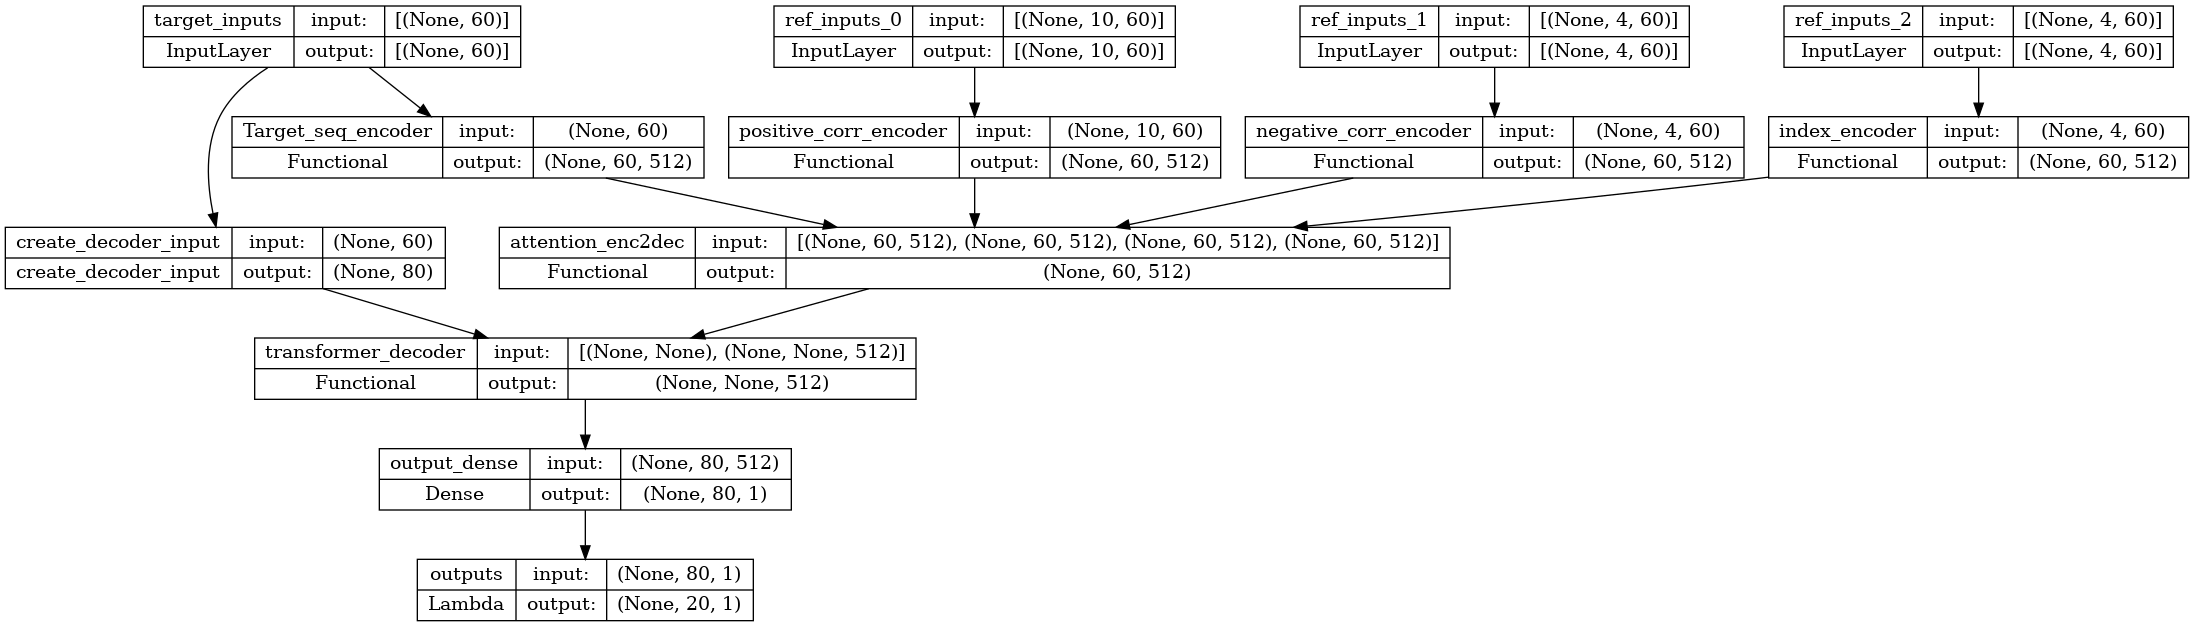

In [57]:
tf.keras.backend.clear_session()

model = MEaI_transformer(
    window_size = params_kospi['window_size'],
    forecast_range = params_kospi['forecast_range'],
    ref_num_list = [10,4,4],
    num_layers = params_kospi['num_layers'],
    dff = params_kospi['dff'],
    d_model = params_kospi['d_model'],
    num_heads = params_kospi['num_heads'],
    dropout = params_kospi['dropout'],
    ref_encoder_name=['positive_corr_encoder','negative_corr_encoder','index_encoder'],
    name="MEaI_transformer")

tf.keras.utils.plot_model(model, to_file='./imgs/KOSPI_MEaI_transformer.png', show_shapes=True)


In [58]:
model.summary()

Model: "MEaI_transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 target_inputs (InputLayer)     [(None, 60)]         0           []                               
                                                                                                  
 ref_inputs_0 (InputLayer)      [(None, 10, 60)]     0           []                               
                                                                                                  
 ref_inputs_1 (InputLayer)      [(None, 4, 60)]      0           []                               
                                                                                                  
 ref_inputs_2 (InputLayer)      [(None, 4, 60)]      0           []                               
                                                                                   

In [59]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.MeanSquaredError()
             )

In [60]:
callback_path = './result/MEaI_transformer_V0_4/KOSPI'

os.makedirs(f'{callback_path}/ckpt', exist_ok=True)
ckpt_path = callback_path+'/ckpt/model_ckpt'
callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    monitor='val_loss',
    save_best_only = True,
    save_weights_only=True,
    verbose=1
)

os.makedirs(f'{callback_path}/tsbd', exist_ok=True)
callback_tsbd = tf.keras.callbacks.TensorBoard(f'{callback_path}/tsbd')

def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * 0.95 
callback_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.00095, 0.0009025, 0.000857375, 0.0008145062499999999, 0.0007737809374999998, 0.0007350918906249997, 0.0006983372960937497, 0.0006634204312890621, 0.000630249409724609, 0.0005987369392383785, 0.0005688000922764595, 0.0005403600876626365, 0.0005133420832795047, 0.00048767497911552944, 0.00046329123015975297, 0.0004401266686517653, 0.00041812033521917703, 0.00039721431845821814, 0.0003773536025353072, 0.0003584859224085418, 0.0003405616262881147, 0.00032353354497370894, 0.00030735686772502346, 0.00029198902433877225, 0.00027738957312183364, 0.0002635200944657419, 0.0002503440897424548, 0.00023782688525533205, 0.00022593554099256544, 0.00021463876394293716, 0.0002039068257457903, 0.00019371148445850077, 0.00018402591023557573, 0.00017482461472379692, 0.00016608338398760707, 0.0001577792147882267, 0.00014989025404881537, 0.00014239574134637458, 0.000

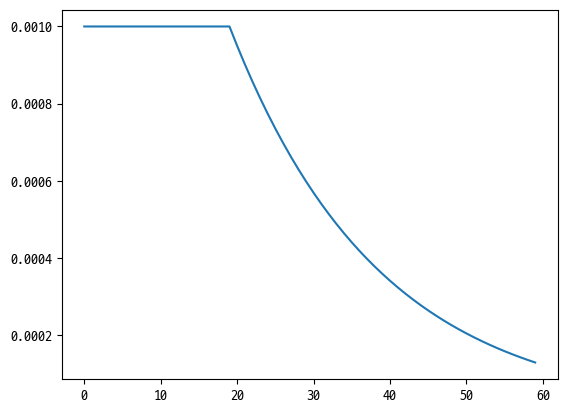

In [61]:
lr = 0.001
e = np.arange(60)

r = [lr for _ in range(len(e))]
for i in range(60):
    lr_ = lr if i == 0 else r[i-1]
    lr_ = scheduler(i, lr_)
    r[i] = lr_

print(r)
plt.plot(e,r)


In [62]:
history_kospi = model.fit(train_dataset, epochs=40, validation_data=valid_dataset, verbose = 1, callbacks=[callback_ckpt,callback_scheduler,callback_tsbd])

Epoch 1/40


ResourceExhaustedError: Exception encountered when calling layer "dense_71" "                 f"(type Dense).

{{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[1280,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:MatMul]

Call arguments received by layer "dense_71" "                 f"(type Dense):
  • inputs=tf.Tensor(shape=(16, 80, 512), dtype=float32)

In [ ]:
model.load_weights('./result/MEaI_transformer_V0_4/KOSPI/ckpt/model_ckpt')

### 결과 예측

In [ ]:
params_kospi

In [ ]:
print(test_traget[np.newaxis,1].shape)
print(test_pos[np.newaxis,1].shape)
print(test_neg[np.newaxis,1].shape)
print(test_index[np.newaxis,1].shape)
print(test_label[np.newaxis,np.newaxis,1,0].shape)

In [ ]:
print(test_traget[np.newaxis,1])
print(test_label[np.newaxis,np.newaxis,1,0])

In [ ]:
out = model([
    test_traget[np.newaxis,1],
    test_pos[np.newaxis,1],
    test_neg[np.newaxis,1],
    test_index[np.newaxis,1],
])

print(out)

In [ ]:
test_label[1,]

In [ ]:
plt.plot(out.numpy().reshape(-1))
plt.plot(test_label[1])

In [ ]:
RESULT_kospi_2 = pd.concat([pd.DataFrame(out.numpy()[0]),KOSPI_MEaI['KOSPI'][-20-fore_range:-fore_range].reset_index(drop=True)],axis=1)
RESULT_kospi_2.columns = ['forecast(MEaI Transformer)','Real value']

RESULT_kospi_2 = RESULT_kospi_2*np.sqrt(scaler_kospi.var_[0])+scaler_kospi.mean_[0] #scale 되돌림

RESULT_kospi_2.to_csv('./MEaI 결과(KOSPI).csv',index=False)

In [ ]:
RESULT_kospi_2.plot()

# 기타 코드

In [ ]:
1792/64